In [1]:
pip install pandas feedparser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import feedparser
import pandas as pd

# Define the RSS feeds with their category labels
feeds = {
    "Health": "http://feeds.bbci.co.uk/news/health/rss.xml",
    "Politics": "http://feeds.bbci.co.uk/news/politics/rss.xml",
    "Business": "http://feeds.bbci.co.uk/news/business/rss.xml"
}

data = []

# Loop through each category and parse feed
for label, url in feeds.items():
    rss = feedparser.parse(url)
    for entry in rss.entries:
        title = entry.get("title", "")
        summary = entry.get("summary", "")
        link = entry.get("link", "")
        text = f"{title} {summary}"  # combine for better classification
        data.append([text, label, link])

# Create DataFrame
df = pd.DataFrame(data, columns=["text", "label", "url"])

# Save to CSV
df.to_csv("bbc_news_dataset.csv", index=False, encoding="utf-8")

print("✅ Dataset saved as bbc_news_dataset.csv")


✅ Dataset saved as bbc_news_dataset.csv


In [3]:
df.head()

,text,label,url
0,Sitting up straight isn't the only secret to g...,Health,https://www.bbc.com/news/articles/c890kejpg34o...
1,Brain image doctor banned for assault and raci...,Health,https://www.bbc.com/news/articles/c3ezk7559j4o...
2,First human case of flesh-eating screwworm par...,Health,https://www.bbc.com/news/articles/c4geyg55jvyo...
3,Call to end airport drop-off fees for blue bad...,Health,https://www.bbc.com/news/articles/cn5e1z6gz5yo...
4,A pea allergy almost killed my boy. It's only ...,Health,https://www.bbc.com/news/articles/cx2pv0z7x3eo...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    200 non-null    object
 1   label   200 non-null    object
 2   url     200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [5]:
# Run this once in a Jupyter cell if needed
!pip install pandas scikit-learn matplotlib


In [6]:
import re
import math
import json
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)
RANDOM_STATE = 42


In [7]:
# Change path if needed
csv_path = "bbc_news_dataset.csv"

df = pd.read_csv(csv_path)
assert {"text","label"}.issubset(df.columns), "CSV must have at least columns: text, label"

df = df.dropna(subset=["text","label"]).reset_index(drop=True)
print("Docs:", len(df), "Classes:", df['label'].nunique(), df['label'].unique())


Docs: 200 Classes: 3 ['Health' 'Politics' 'Business']


In [8]:
df.head(3)


,text,label,url
0,Sitting up straight isn't the only secret to good posture - here are three more tips Here are Dr Xand's three sugges...,Health,https://www.bbc.com/news/articles/c890kejpg34o?at_medium=RSS&at_campaign=rss
1,"Brain image doctor banned for assault and racism Dr Sayed Talibi is told his conduct was ""fundamentally incompatible...",Health,https://www.bbc.com/news/articles/c3ezk7559j4o?at_medium=RSS&at_campaign=rss
2,First human case of flesh-eating screwworm parasite confirmed in US New World screwworm myiasis was found in a patie...,Health,https://www.bbc.com/news/articles/c4geyg55jvyo?at_medium=RSS&at_campaign=rss


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

TOKEN_RE = re.compile(r"[A-Za-z][A-Za-z0-9_]+")

STOPWORDS = set(ENGLISH_STOP_WORDS)
def tokenize(text):
    toks = [t.lower() for t in TOKEN_RE.findall(text)]
    return [t for t in toks if len(t) > 1 and t not in STOPWORDS]

def build_inverted_index(texts):
    postings = defaultdict(list)  # term -> list of (doc_id, tfidf_weight)
    df_counts = Counter()
    per_doc_tf = []

    # raw term counts per doc + document frequencies
    for doc_id, text in enumerate(texts):
        counts = Counter(tokenize(text))
        per_doc_tf.append(counts)
        for term in counts:
            df_counts[term] += 1

    N = len(texts)
    # smooth idf
    idf = {term: np.log((1 + N) / (1 + df_)) + 1.0 for term, df_ in df_counts.items()}

    # compute tf-idf & doc norms
    doc_norms = np.zeros(N, dtype=float)
    for doc_id, counts in enumerate(per_doc_tf):
        for term, tf in counts.items():
            w = (1.0 + np.log(tf)) * idf[term]  # log-tf * idf
            postings[term].append((doc_id, w))
            doc_norms[doc_id] += w * w
    doc_norms = np.sqrt(doc_norms)
    return postings, idf, doc_norms

postings, IDF, DOC_NORMS = build_inverted_index(df['text'].tolist())
len(postings), len(IDF), len(DOC_NORMS)


(1748, 1748, 200)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Use text column
corpus = df['text'].tolist()

# Fit TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get feature names and IDF values
terms = tfidf_vectorizer.get_feature_names_out()
idfs = tfidf_vectorizer.idf_

idf_df = pd.DataFrame({"term": terms, "idf": idfs}).sort_values("idf", ascending=False)

print("TF-IDF matrix shape:", tfidf_matrix.shape)
idf_df.head(10)


TF-IDF matrix shape: (200, 1782)


,term,idf
1781,yvette,5.610158
1780,youth,5.610158
1760,wondering,5.610158
1759,won,5.610158
1757,wolverhampton,5.610158
1756,woes,5.610158
1755,withdrawing,5.610158
1754,witch,5.610158
1753,wish,5.610158
1751,wing,5.610158


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: similarity of doc 0 with all others
sim_scores = list(enumerate(cosine_sim_matrix[0]))
sim_scores_sorted = sorted(sim_scores, key=lambda x: -x[1])[1:6]  # top-5 excluding itself

print("Top-5 most similar documents to doc 0:")
for idx, score in sim_scores_sorted:
    print(f"Doc {idx} | Similarity={score:.4f} | Title={df.loc[idx,'text']}")

Top-5 most similar documents to doc 0:
Doc 18 | Similarity=0.1219 | Title=Hot weather: How to sleep in the heat Simple tips to help you get a good night's sleep during hot weather.
Doc 15 | Similarity=0.0986 | Title=What should you look for when choosing sunscreen? What to look for when choosing sunscreen and how to apply it to get the maximum protection.
Doc 136 | Similarity=0.0905 | Title=Are latest UK growth figures good or bad news for the economy? Depending on the timeframe you look at, the GDP figures can be seen as glass half full or half empty.
Doc 54 | Similarity=0.0610 | Title=The junior doctors' strikes may be over. But is trouble ahead? The end of the pay dispute sounded too good to be true. And now some are wondering if it might be.
Doc 1 | Similarity=0.0602 | Title=Brain image doctor banned for assault and racism Dr Sayed Talibi is told his conduct was "fundamentally incompatible" with being a doctor.


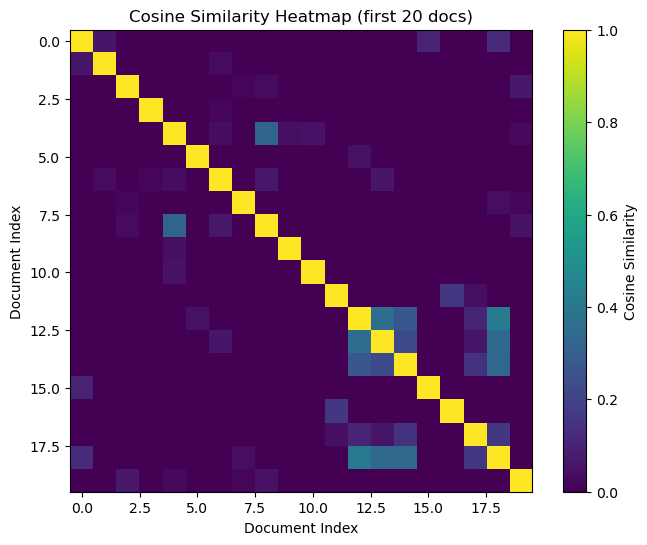

In [12]:
import matplotlib.pyplot as plt

# Take a small subset (e.g., first 20 documents) for visualization
subset_sim = cosine_sim_matrix[:20, :20]

plt.figure(figsize=(8,6))
plt.imshow(subset_sim, cmap='viridis')
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Heatmap (first 20 docs)")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

In [13]:
print("Docs:", len(df), "Classes:", df['label'].nunique(), df['label'].unique())

Docs: 200 Classes: 3 ['Health' 'Politics' 'Business']


In [14]:
STOPWORDS = ENGLISH_STOP_WORDS

token_pattern = re.compile(r"[A-Za-z]+")  # keep words only; adjust if you want digits

def tokenize(s: str):
    s = s.lower()
    toks = token_pattern.findall(s)
    return [t for t in toks if t not in STOPWORDS and len(t) >= 2]


In [15]:
# Store tokens per doc for phrase checks
doc_tokens = []
for text in df["text"]:
    doc_tokens.append(tokenize(text))

# Build inverted index: term -> {doc_id: [positions]}
inverted_index = defaultdict(lambda: defaultdict(list))
for doc_id, toks in enumerate(doc_tokens):
    for pos, tok in enumerate(toks):
        inverted_index[tok][doc_id].append(pos)

# Precompute doc frequencies & idf (smoothed)
N = len(df)
dfreq = {term: len(postings) for term, postings in inverted_index.items()}
idf = {term: math.log((N + 1) / (dfreq[term] + 1)) + 1.0 for term in dfreq}

print("Vocabulary size:", len(inverted_index))


Vocabulary size: 1748


In [16]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, preprocessor=None, lowercase=False, token_pattern=None)


In [17]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, preprocessor=None, lowercase=False)
X_tfidf = vectorizer.fit_transform(df["text"])
vocab = vectorizer.vocabulary_  # term -> column index


C:\Users\Acer Aspire\Downloads\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
OPERATORS = {"AND", "OR", "NOT"}

def phrase_match_docs(phrase_tokens):
    """Return set of doc_ids that contain the phrase (consecutive tokens)."""
    if not phrase_tokens:
        return set()
    # Start from candidate docs containing all tokens
    candidate_docs = set(range(N))
    for t in phrase_tokens:
        candidate_docs &= set(inverted_index.get(t, {}).keys())
    # Verify consecutive order
    hits = set()
    for d in candidate_docs:
        toks = doc_tokens[d]
        if len(toks) < len(phrase_tokens):
            continue
        # Sliding window
        L = len(phrase_tokens)
        for i in range(len(toks) - L + 1):
            if toks[i:i+L] == phrase_tokens:
                hits.add(d); break
    return hits

def postings_for_term(term):
    return set(inverted_index.get(term, {}).keys())

def parse_query(q):
    """Extract phrases and tokens. Returns list of tokens where phrases are joined by spaces but wrapped as <PHRASE:...>."""
    # Find quoted phrases
    phrases = re.findall(r'"([^"]+)"', q)
    placeholder = {}
    for i, ph in enumerate(phrases):
        key = f"<PHRASE_{i}>"
        placeholder[key] = ph
        q = q.replace(f"\"{ph}\"", key)
    # Split remaining by whitespace
    parts = q.strip().split()
    # Put phrases back
    tokens = []
    for p in parts:
        if p in placeholder:
            tokens.append(("PHRASE", placeholder[p]))
        else:
            tokens.append(("TERM_OR_OP", p))
    return tokens

def to_rpn(tokens):
    """Shunting-yard to handle precedence: NOT > AND > OR."""
    precedence = {"NOT": 3, "AND": 2, "OR": 1}
    output, stack = [], []
    for typ, val in tokens:
        if typ == "PHRASE":
            output.append(("PHRASE", val))
        else:
            t = val
            u = t.upper()
            if u in OPERATORS:
                while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[u]:
                    output.append(("OP", stack.pop()))
                stack.append(u)
            else:
                output.append(("TERM", t))
    while stack:
        output.append(("OP", stack.pop()))
    return output

def eval_boolean_rpn(rpn):
    """Evaluate boolean RPN to a set of doc_ids."""
    universe = set(range(N))
    st = []
    for typ, val in rpn:
        if typ == "TERM":
            st.append(postings_for_term(val.lower()))
        elif typ == "PHRASE":
            st.append(phrase_match_docs(tokenize(val)))
        elif typ == "OP":
            if val == "NOT":
                a = st.pop()
                st.append(universe - a)
            elif val in ("AND", "OR"):
                b, a = st.pop(), st.pop()
                st.append(a & b if val == "AND" else a | b)
    return st[0] if st else set()

def ranked_search(query, k=10, restrict_to=None):
    """TF-IDF cosine similarity; optionally restrict to a set of doc_ids (post-filter from boolean/phrase)."""
    qvec = vectorizer.transform([query])
    sims = (X_tfidf @ qvec.T).toarray().ravel()
    idx = np.argsort(-sims)
    if restrict_to is not None:
        mask = np.array([i for i in idx if i in restrict_to])
        idx = mask
    idx = [i for i in idx if sims[i] > 0]
    top = idx[:k]
    return pd.DataFrame({
        "score": sims[top],
        "label": df.loc[top, "label"].values,
        "text": df.loc[top, "text"].values,
        "url": df.loc[top, "url"].values if "url" in df.columns else [""]*len(top),
        "doc_id": top
    })

def search(query, k=10):
    tokens = parse_query(query)
    has_bool = any((t == "TERM_OR_OP" and v.upper() in OPERATORS) for t, v in tokens)
    has_phrase = any(t == "PHRASE" for t, _ in tokens)
    if has_bool or has_phrase:
        rpn = to_rpn(tokens)
        candidate = eval_boolean_rpn(rpn)
        return ranked_search(query, k=k, restrict_to=candidate)
    else:
        return ranked_search(query, k=k)

# Quick sanity checks:
display(search('hot weather', k=5))

,score,label,text,url,doc_id
0,0.656339,Health,"What does hot weather do to the body? Hot weather during the summer can affect anyone, but some people run a greater...",https://www.bbc.com/news/articles/cy7n6m7y6yvo?at_medium=RSS&at_campaign=rss,12
1,0.630155,Health,Hot weather: How to sleep in the heat Simple tips to help you get a good night's sleep during hot weather.,https://www.bbc.com/news/articles/cpw7gp2ky70o?at_medium=RSS&at_campaign=rss,18
2,0.541661,Health,When is it too hot to walk your dog? How to make sure your pets are cool and comfortable during periods of hot weather.,https://www.bbc.com/news/articles/ce839egxynwo?at_medium=RSS&at_campaign=rss,13
3,0.413234,Health,What to do if you think someone has heat exhaustion or heatstroke Know the signs and what to do if someone is unwell...,https://www.bbc.com/news/articles/ckgl51jjp3jo?at_medium=RSS&at_campaign=rss,14
4,0.155481,Health,How do heat health alerts work? The weather alert service warns the public when high or low temperatures could damag...,https://www.bbc.com/news/articles/cd97dkx9g38o?at_medium=RSS&at_campaign=rss,17


In [19]:
display(search('"hot weather"', k=5))

,score,label,text,url,doc_id
0,0.656339,Health,"What does hot weather do to the body? Hot weather during the summer can affect anyone, but some people run a greater...",https://www.bbc.com/news/articles/cy7n6m7y6yvo?at_medium=RSS&at_campaign=rss,12
1,0.630155,Health,Hot weather: How to sleep in the heat Simple tips to help you get a good night's sleep during hot weather.,https://www.bbc.com/news/articles/cpw7gp2ky70o?at_medium=RSS&at_campaign=rss,18
2,0.541661,Health,When is it too hot to walk your dog? How to make sure your pets are cool and comfortable during periods of hot weather.,https://www.bbc.com/news/articles/ce839egxynwo?at_medium=RSS&at_campaign=rss,13
3,0.413234,Health,What to do if you think someone has heat exhaustion or heatstroke Know the signs and what to do if someone is unwell...,https://www.bbc.com/news/articles/ckgl51jjp3jo?at_medium=RSS&at_campaign=rss,14


In [20]:
display(search('health AND weather AND NOT dog', k=5))

,score,label,text,url,doc_id
0,0.285722,Health,How do heat health alerts work? The weather alert service warns the public when high or low temperatures could damag...,https://www.bbc.com/news/articles/cd97dkx9g38o?at_medium=RSS&at_campaign=rss,17


In [21]:
X = df["text"].values
y = df["label"].values

# Stratified split (fallback if too few samples)
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )
except ValueError:
    # If very small dataset, do a simple split without stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE
    )

print("Train:", len(X_train), "Test:", len(X_test))


Train: 150 Test: 50


In [22]:
# Shared vectorizer: strong, simple defaults
def make_text_pipeline(clf):
    return make_pipeline(
        TfidfVectorizer(tokenizer=tokenize, preprocessor=None, lowercase=False, ngram_range=(1,2), min_df=2, stop_words=None),
        clf
    )

logreg = LogisticRegression(max_iter=2000, solver="liblinear", multi_class="ovr", random_state=RANDOM_STATE)
nb = MultinomialNB()

pipe_lr = make_text_pipeline(logreg)
pipe_nb = make_text_pipeline(nb)

pipe_lr.fit(X_train, y_train)
pipe_nb.fit(X_train, y_train)

pred_lr = pipe_lr.predict(X_test)
pred_nb = pipe_nb.predict(X_test)

acc_lr = accuracy_score(y_test, pred_lr)
acc_nb = accuracy_score(y_test, pred_nb)

print(f"Accuracy — Logistic Regression: {acc_lr:.3f}")
print(f"Accuracy — Multinomial NB     : {acc_nb:.3f}")


Accuracy — Logistic Regression: 0.660
Accuracy — Multinomial NB     : 0.700


C:\Users\Acer Aspire\Downloads\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Acer Aspire\Downloads\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Acer Aspire\Downloads\anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [23]:
print("\n=== Logistic Regression ===")
print(classification_report(y_test, pred_lr, zero_division=0))
cm_lr = confusion_matrix(y_test, pred_lr, labels=sorted(df['label'].unique()))
print("Confusion matrix (LR):\n", cm_lr)


=== Logistic Regression ===
              precision    recall  f1-score   support

    Business       1.00      0.09      0.17        11
      Health       0.62      0.96      0.75        24
    Politics       0.75      0.60      0.67        15

    accuracy                           0.66        50
   macro avg       0.79      0.55      0.53        50
weighted avg       0.74      0.66      0.60        50

Confusion matrix (LR):
 [[ 1  8  2]
 [ 0 23  1]
 [ 0  6  9]]


In [24]:
print("\n=== Multinomial Naive Bayes ===")
print(classification_report(y_test, pred_nb, zero_division=0))
cm_nb = confusion_matrix(y_test, pred_nb, labels=sorted(df['label'].unique()))
print("Confusion matrix (NB):\n", cm_nb)


=== Multinomial Naive Bayes ===
              precision    recall  f1-score   support

    Business       1.00      0.09      0.17        11
      Health       0.68      0.96      0.79        24
    Politics       0.73      0.73      0.73        15

    accuracy                           0.70        50
   macro avg       0.80      0.59      0.56        50
weighted avg       0.76      0.70      0.64        50

Confusion matrix (NB):
 [[ 1  7  3]
 [ 0 23  1]
 [ 0  4 11]]


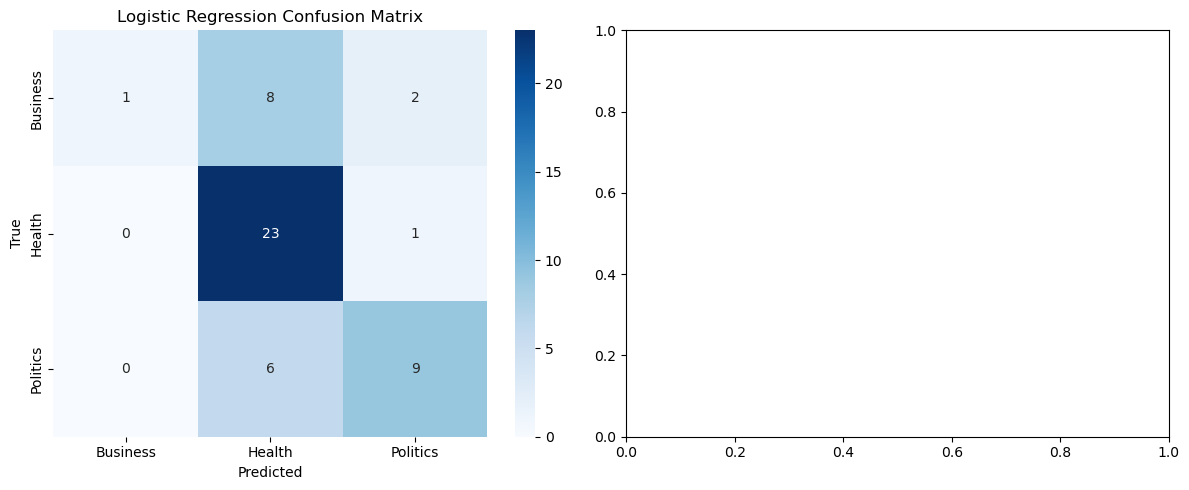

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get labels (sorted for consistency)
labels = sorted(df['label'].unique())

# Confusion matrices
cm_lr = confusion_matrix(y_test, pred_lr, labels=labels)
cm_nb = confusion_matrix(y_test, pred_nb, labels=labels)

# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

plt.tight_layout()
plt.show()

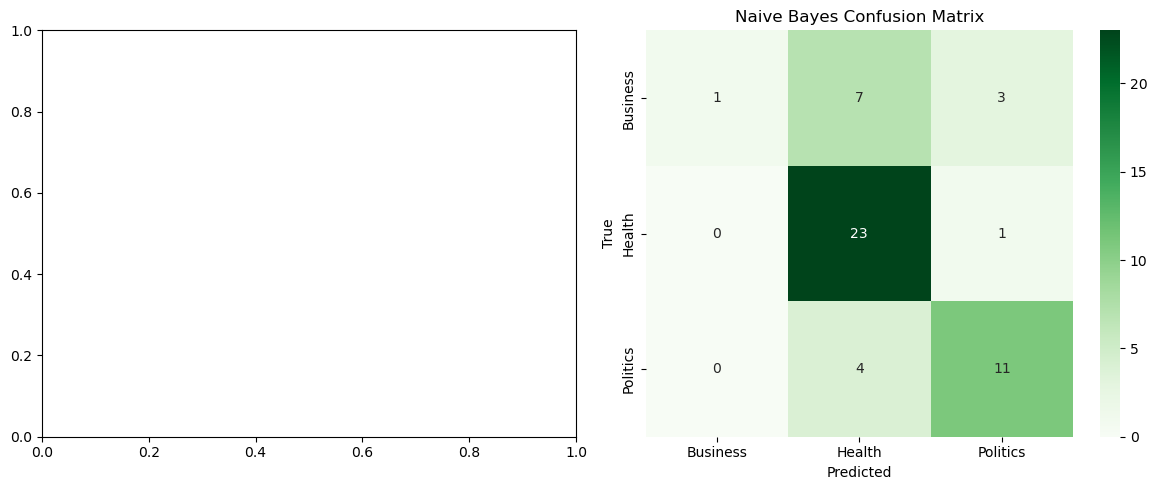

In [26]:
# --- Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Naive Bayes Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

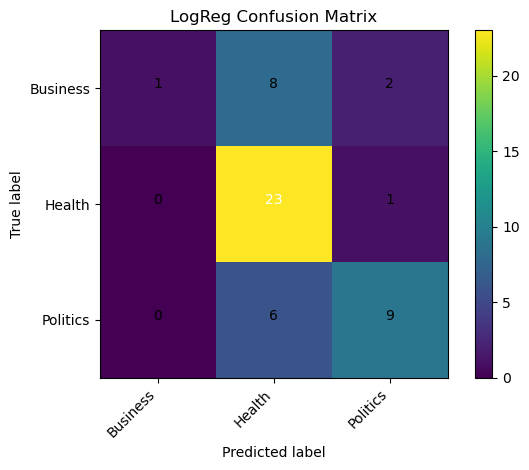

In [27]:
import matplotlib.pyplot as plt
import itertools

def plot_cm(cm, classes, title="Confusion matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

labels = sorted(pd.unique(y_test))
cm_lr = confusion_matrix(y_test, pred_lr, labels=labels)
cm_nb = confusion_matrix(y_test, pred_nb, labels=labels)

plot_cm(cm_lr, labels, "LogReg Confusion Matrix")


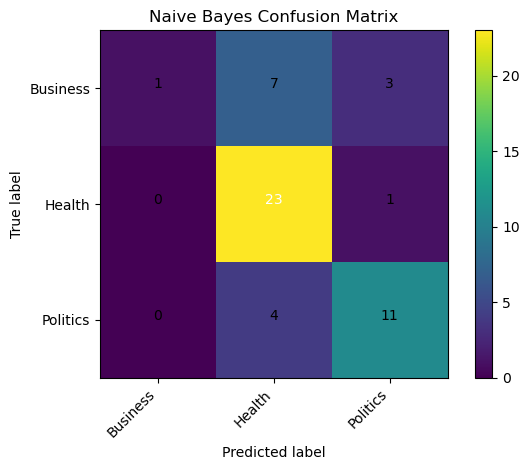

In [28]:
plot_cm(cm_nb, labels, "Naive Bayes Confusion Matrix")

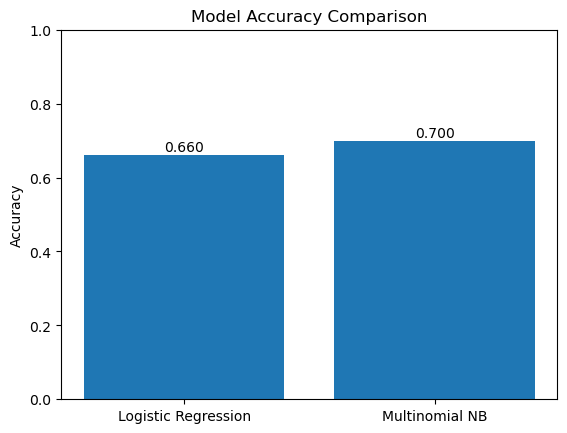

In [29]:
models = ["Logistic Regression", "Multinomial NB"]
scores = [acc_lr, acc_nb]

plt.figure()
plt.bar(models, scores)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()


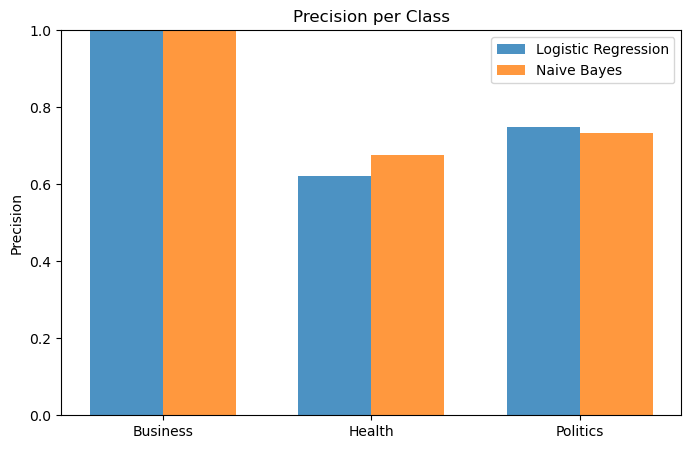

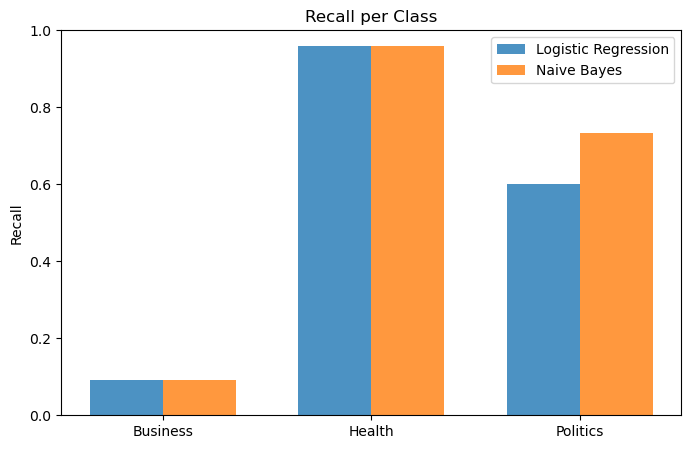

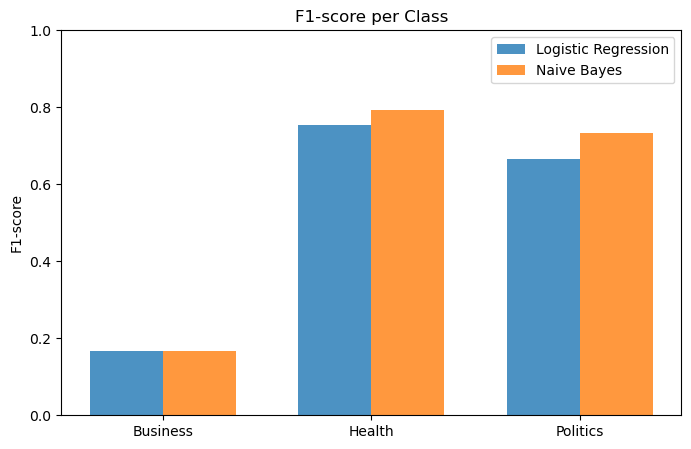

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, F1 for each class
labels = sorted(pd.unique(y_test))
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(y_test, pred_lr, labels=labels, zero_division=0)
prec_nb, rec_nb, f1_nb, _ = precision_recall_fscore_support(y_test, pred_nb, labels=labels, zero_division=0)

metrics = {
    "Precision": (prec_lr, prec_nb),
    "Recall": (rec_lr, rec_nb),
    "F1-score": (f1_lr, f1_nb)
}

# Plot grouped bar chart for each metric
x = np.arange(len(labels))  # label locations
width = 0.35

for metric_name, (lr_vals, nb_vals) in metrics.items():
    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, lr_vals, width, label="Logistic Regression", alpha=0.8)
    plt.bar(x + width/2, nb_vals, width, label="Naive Bayes", alpha=0.8)

    plt.xticks(x, labels)
    plt.ylim(0,1)
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} per Class")
    plt.legend()
    plt.show()
